In [1]:
import numpy as np
from scipy.optimize import minimize
from mygp import gp, kernel
import corner
import emcee

# setup plotting
import matplotlib.pyplot as pl
%matplotlib inline
import seaborn as sns
palette = sns.color_palette()
sns.set()

In [2]:
# sample a GP with the given parameters, mean, and number of samples (at points t)
# params = [log_l, log_wn1...log_wnn, c1...cn, mean_params1...mean_paramsn]
def make_data(params, mean_func, n_samples, t):
    log_l = params[0]
    log_wn = params[1:n_samples+1]
    
    if n_samples > 1:
        c = np.concatenate(([1], params[n_samples+1: 2*n_samples]))
        mean_params = params[2*n_samples:]
        k2 = kernel.scale_kernel([scale for scale in c])
    else:
        mean_params = params[n_samples+1:]
        k2 = None

    mean = lambda x: mean_func(x, *mean_params)
    k1 = kernel.exp_sq_kernel(np.exp(log_l), 10)
    
    dim = (n_samples > 1) + 1
    g = gp(mean, k1, kernel2=k2, wn=[np.exp(lwn) for lwn in log_wn], dim=dim)
    g.compute(t)
    data = g.sample()
    return data 

# returns the negative log likelihood for the GP with given parameters, mean, etc. as above
def neg_log_like(params, mean_func, n_samples, t, data):
    log_l = params[0]
    log_wn = params[1:n_samples+1]
    
    if n_samples > 1:
        c = np.concatenate(([1], params[n_samples+1: 2*n_samples]))
        mean_params = params[2*n_samples:]
        k2 = kernel.scale_kernel([scale for scale in c])
    else:
        mean_params = params[n_samples+1:]
        k2 = None
    
    mean = lambda x: mean_func(x, *mean_params)
    k1 = kernel.exp_sq_kernel(np.exp(log_l), 10)
    
    dim = (n_samples > 1) + 1
    g = gp(mean, k1, kernel2=k2, wn=[np.exp(lwn) for lwn in log_wn], dim=dim)
    g.compute(t)
    nll = -g.log_likelihood(data, x=t)
    return nll

# print the parameters nicely 
def print_params(params, n_samples):
    log_l = params[0]
    log_wn = params[1:n_samples+1]
    
    if n_samples > 1:
        c = np.concatenate(([1], params[n_samples+1: 2*n_samples]))
        mean_params = params[2*n_samples:]
    else:
        mean_params = params[n_samples+1:]
        k2 = None
    
    print('mean parameters: ', mean_params)
    print('l: ', np.exp(log_l))
    print('white noise: ', np.exp(log_wn))
    if n_samples > 1:
        print('scale factor: ', c)

# minimizes the negative log likelihood using L-BFGS-B
def fit_n_samples(p0, n_samples, data, t):
    func = lambda p: neg_log_like(p, gauss, n_samples, t, data)
    
    if n_samples > 1:
        log_bounds = [(-np.inf, np.inf) for i in range(n_samples+1)]
        reg_bounds = [(0, np.inf) for i in range(n_samples-1)]
        mean_bounds = [(0, np.inf) for i in range(3)]
        bounds = np.concatenate((log_bounds, reg_bounds, mean_bounds))
    
    else: 
        bounds = [(-np.inf, np.inf), (-np.inf, np.inf), (0, np.inf), (0, np.inf), (0, np.inf)]
    
    min_params = minimize(func, x0=p0, bounds=bounds, method='L-BFGS-B')
    return min_params.x

# does mcmc
def do_mcmc(p0, n_samples, n_steps, n_walkers, n_burnin, data, t):
    log_like = lambda p0, mean_func, n_samples, t, data: -neg_log_like(p0, mean_func, n_samples, t, data)

    ndim, nwalkers = len(p0), n_walkers
    p0 = [p0 + 1e-4*np.random.randn(len(p0)) for i in range(nwalkers)]

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_like, args=[gauss, n_samples, t, data])
    sampler.run_mcmc(p0, n_steps)
    samples = sampler.chain[:, n_burnin:, :].reshape((-1, ndim))
    return samples

In [5]:
# parameters for true mean and gp

t0 = 5
sig = 0.5
A = 30
true_params = np.log(0.5), np.log(4), np.log(4), np.log(6), 2, 4, A, t0, sig
t_single = np.linspace(0, 10, 300)
t = t_single[::3]
tp = np.linspace(0, 10, 1000)

def gauss(t, A, t0, sig):
    return A*np.exp(-((t - t0)**2)/(2*sig*sig))

In [25]:
# make the fake data

data = make_data(true_params, gauss, 3, t_single)
data_single = data[0]
y1, y2, y3 = [d[::3] for d in data]

/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:35: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims)


True Parameters
---------------
mean parameters:  (30, 5, 0.5)
l:  0.5
white noise:  [4. 4. 6.]
scale factor:  [1 2 4]


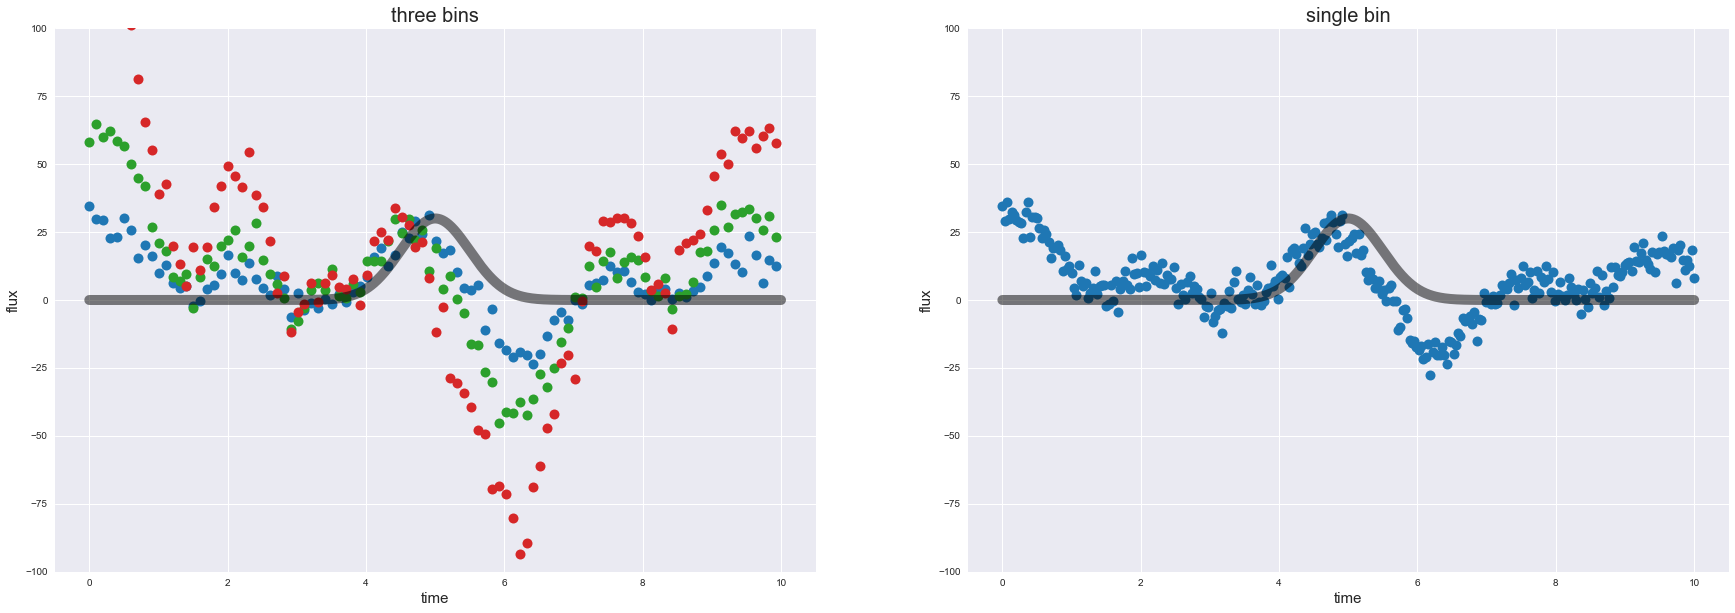

In [26]:
# plot the fake data and underlying mean 

fig, axs = pl.subplots(1, 2, figsize=(30, 10))

axs[0].plot(t, y1, 'o', alpha=1, color=palette[0], markersize=10)
axs[0].plot(t, y2, 'o', alpha=1, color=palette[2], markersize=10)
axs[0].plot(t, y3, 'o', alpha=1, color=palette[3], markersize=10)
axs[0].plot(tp, gauss(tp, A, t0, sig), linewidth=10, color='k', alpha=0.5)

axs[1].plot(t_single, data_single, 'o', alpha=1, color=palette[0], markersize=10)
axs[1].plot(tp, gauss(tp, A, t0, sig), linewidth=10, color='k', alpha=0.5)

axs[0].set_title('three bins', size=20)
axs[0].set_xlabel('time', size=15)
axs[0].set_ylabel('flux', size=15)

axs[1].set_title('single bin', size=20)
axs[1].set_xlabel('time', size=15)
axs[1].set_ylabel('flux', size=15)

axs[0].set_ylim(-100, 100)
axs[1].set_ylim(-100, 100)

print('True Parameters')
print('---------------')
print_params(true_params, 3)

/Users/tgordon/research/gp2d/mygp.py:194: RuntimeWarning: overflow encountered in double_scalars
  self.detK = np.prod(np.diag(self.L))**2


Best Fit Parameters - Multiple Bins
---------------
mean parameters:  [31.72058995  4.9548326   0.51450755]
l:  0.5722342627542035
white noise:  [3.5096553  4.03287087 5.96500536]
scale factor:  [1.         2.0788077  4.03554162]
 
Best Fit Parameters - Single Bin
---------------
mean parameters:  [23.46079518  4.69540633  0.42581968]
l:  0.6472649702200143
white noise:  [3.8607642]


(-100, 100)

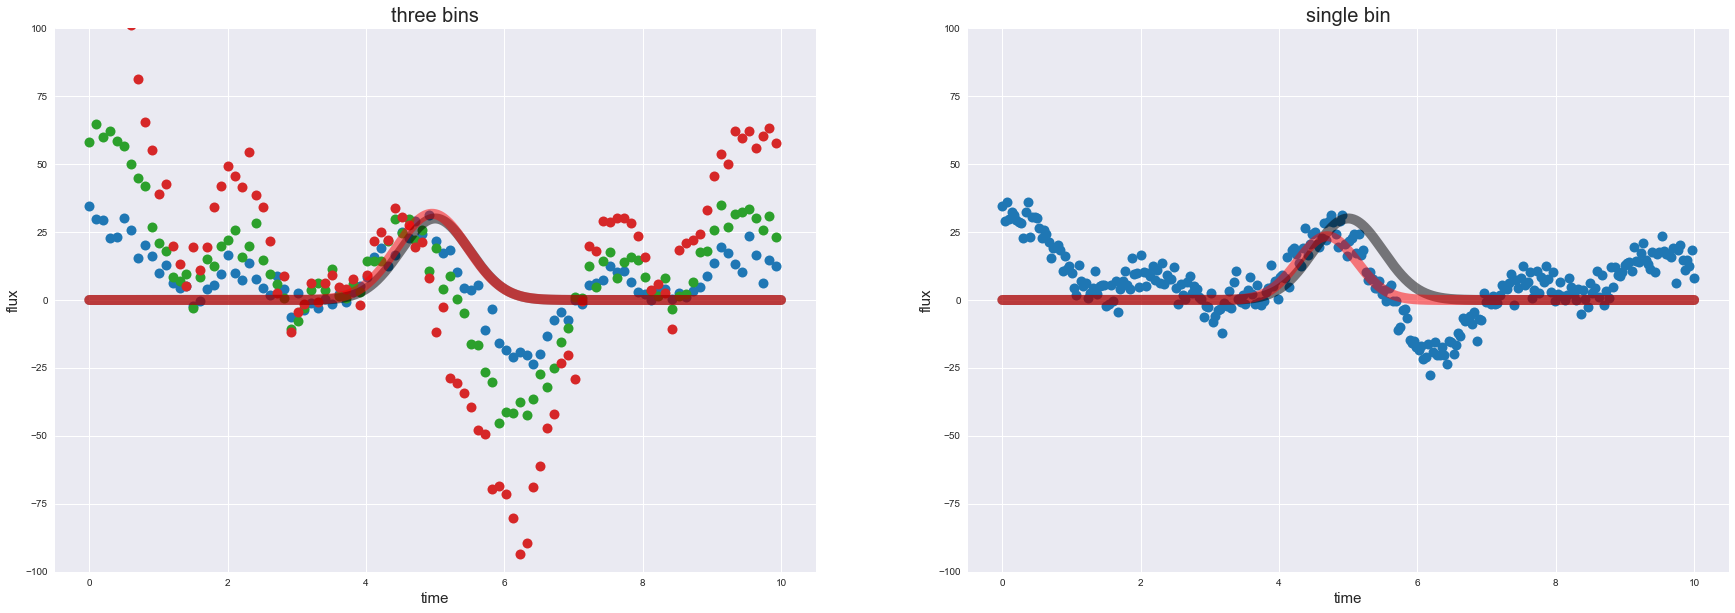

In [27]:
# minimize the single and triple-wavelength cases and plot the fits. 

# three wavelength case
p0 = [np.log(0.4), np.log(0.7), np.log(3.5), np.log(4.5), 1.5, 3, 50, 5, 1]
# L-BFGS-B minimization
min_params_multi = fit_n_samples(p0, 3, [y1, y2, y3], t)

# single wavelength case
p0 = [np.log(0.4), np.log(0.7), 50, 5, 1]
# L-BFGS-B minimization 
min_params_single = fit_n_samples(p0, 1, data_single, t_single)

# print the best fit parameters for both cases
print('Best Fit Parameters - Multiple Bins')
print('---------------')
print_params(min_params_multi, 3)
print(' ')
print('Best Fit Parameters - Single Bin')
print('---------------')
print_params(min_params_single, 1)

# plot fits
fig, axs = pl.subplots(1, 2, figsize=(30, 10))
axs[0].plot(t, y1, 'o', alpha=1, color=palette[0], markersize=10)
axs[0].plot(t, y2, 'o', alpha=1, color=palette[2], markersize=10)
axs[0].plot(t, y3, 'o', alpha=1, color=palette[3], markersize=10)
axs[0].plot(tp, gauss(tp, A, t0, sig), linewidth=10, color='k', alpha=0.5)
axs[0].plot(tp, gauss(tp, min_params_multi[-3], min_params_multi[-2], min_params_multi[-1]), linewidth=10, color='r', alpha=0.5)

axs[1].plot(t_single, data_single, 'o', alpha=1, color=palette[0], markersize=10)
axs[1].plot(tp, gauss(tp, A, t0, sig), linewidth=10, color='k', alpha=0.5)
axs[1].plot(tp, gauss(tp, min_params_single[-3], min_params_single[-2], min_params_single[-1]), linewidth=10, color='r', alpha=0.5)

axs[0].set_title('three bins', size=20)
axs[0].set_xlabel('time', size=15)
axs[0].set_ylabel('flux', size=15)

axs[1].set_title('single bin', size=20)
axs[1].set_xlabel('time', size=15)
axs[1].set_ylabel('flux', size=15)

axs[0].set_ylim(-100, 100)
axs[1].set_ylim(-100, 100)

In [ ]:
# do mcmc starting from best fit parameters for the three wavelength case

p0 = min_params_multi
log_like = lambda p0, mean_func, n_samples, t, data: -neg_log_like(p0, mean_func, n_samples, t, data)
samples = do_mcmc(p0, 3, 100, 100, 50, [y1, y2, y3], t)
fig = corner.corner(samples, labels=['l', 'wn1', 'wn2', 'wn3', 'c1', 'c2', 'A', 't0', 'sig'])

/Users/tgordon/research/gp2d/mygp.py:194: RuntimeWarning: overflow encountered in double_scalars
  self.detK = np.prod(np.diag(self.L))**2


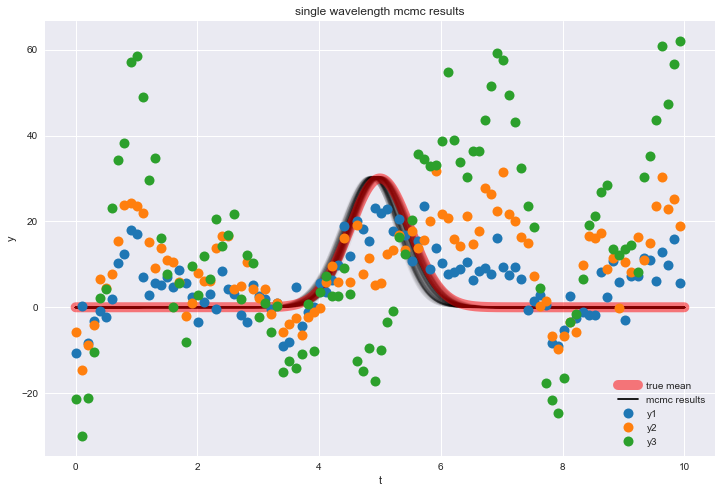

In [8]:
# plot some samples from the mcmc chain over the true mean and data

fig = pl.figure(figsize=(12, 8))

for s in samples[np.random.randint(len(samples), size=50)]:
    pl.plot(tp, gauss(tp, s[-3], s[-2], s[-1]), color='k', alpha=0.1)
    
pl.plot(tp, gauss(tp, A, t0, sig), linewidth=10, color='r', alpha=0.5, label='true mean')
pl.plot(0, 0, color='k', label='mcmc results')
pl.plot(t, y1, 'o', alpha=1, color=palette[0], markersize=10, label='y1')
pl.plot(t, y2, 'o', alpha=1, color=palette[1], markersize=10, label='y2')
pl.plot(t, y3, 'o', alpha=1, color=palette[2], markersize=10, label='y3')
pl.title('single wavelength mcmc results')
pl.xlabel('t')
pl.ylabel('y')
pl.legend()

/Users/tgordon/research/gp2d/mygp.py:194: RuntimeWarning: overflow encountered in double_scalars
  self.detK = np.prod(np.diag(self.L))**2


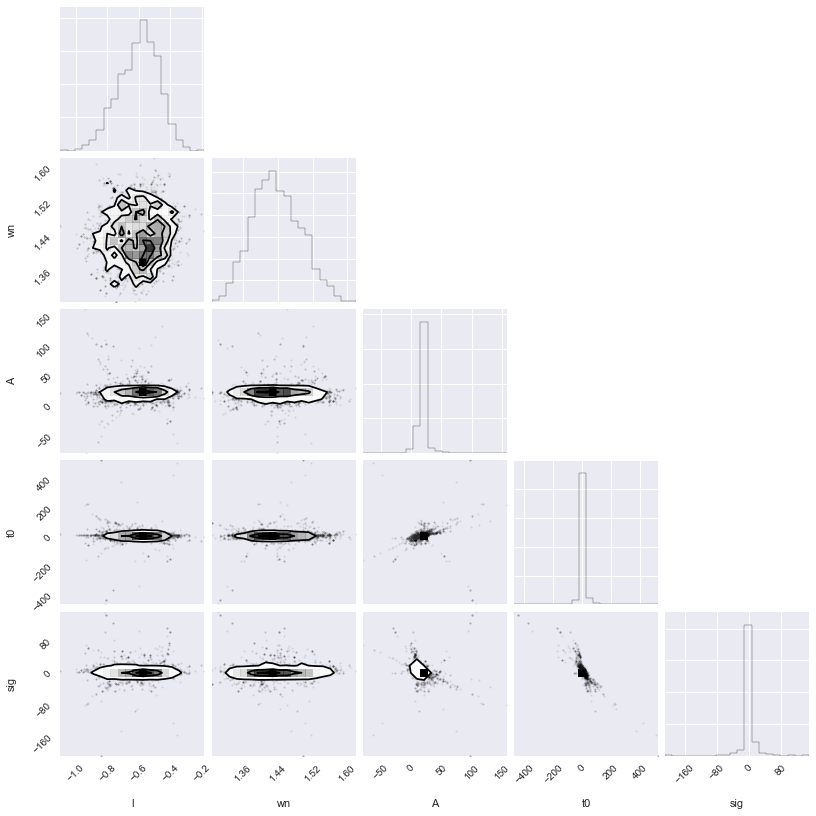

In [9]:
# run mcmc on the single wavelength case

p0 = min_params_single
log_like = lambda p0, mean_func, n_samples, t, data: -neg_log_like(p0, mean_func, n_samples, t, data)
samples = do_mcmc(p0, 1, 100, 100, 50, data_single, t_single)
fig = corner.corner(samples, labels=['l', 'wn', 'A', 't0', 'sig'])

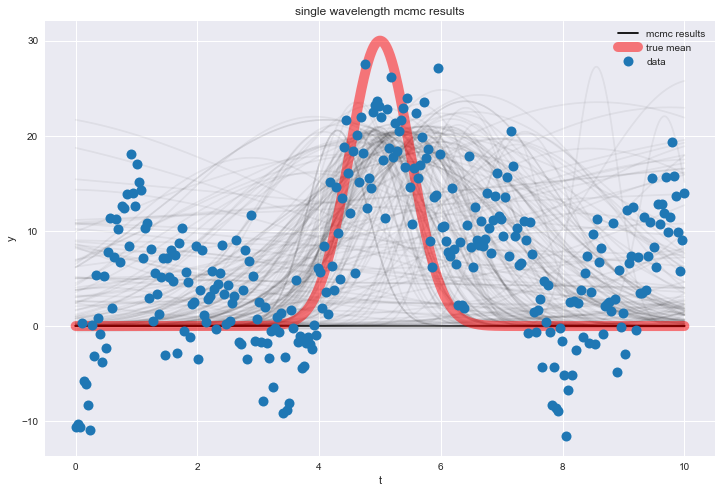

In [15]:
# plot some mcmc samples from the single wavelength case over the data and true mean

fig = pl.figure(figsize=(12, 8))
for s in samples[np.random.randint(len(samples), size=50)]:
    pl.plot(tp, gauss(tp, s[-3], s[-2], s[-1]), color='k', alpha=0.05)
    
pl.plot(0, 0, color='k', label='mcmc results')
pl.plot(tp, gauss(tp, A, t0, sig), linewidth=10, color='r', alpha=0.5, label='true mean')
pl.plot(t_single, data_single, 'o', alpha=1, color=palette[0], markersize=10, label='data')
pl.title('single wavelength mcmc results')
pl.xlabel('t')
pl.ylabel('y')
pl.legend()